#2024 SU Bioinformatics —— Secondary structure prediction project
Zhouhui Qi

README


This document pertains to various neural network algorithms for predicting the secondary structure of proteins. It encompasses four distinct architectures, including MLP, CNN, RNN, and Transformer. Despite similarities in data preprocessing across different approaches, there are still nuanced differences due to the varying structures of neural networks. Consequently, to maintain code clarity, all methods have not been consolidated but rather divided into five main sections, each runnable independently. For comprehensive analysis, please refer to the accompanying report.

Additionally, it should be noted that while the MLP model is capable of accepting data in protein sequence or PSSM formats, for RNN, CNN, and Transformer architectures, due to their specific structures, higher accuracy is currently achieved only with input data in PSSM format. Therefore, these three architectures are provided solely for reference, to enable comparison and evaluation of MLP performance.

To run the program, you need to run "Load training data" first, and then you can run each method individually.

#Load training data

In [ ]:
# The following code is adapted from Katarina Elez (https://github.com/katarinaelez/protein-ss-pred)

!git clone https://github.com/katarinaelez/protein-ss-pred.git

Cloning into 'protein-ss-pred'...
remote: Enumerating objects: 3151, done.
remote: Total 3151 (delta 0), reused 0 (delta 0), pack-reused 3151
Receiving objects: 100% (3151/3151), 18.89 MiB | 21.50 MiB/s, done.
Resolving deltas: 100% (588/588), done.


#1. Method 1 MLP with PSSM and protein sequence as input

##1.1 Model Training

###1.1.1 Load packages

In [ ]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import os.path
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

###1.1.2 Process data into a format consistent with neural network

In [ ]:
# Utility functions to parse data fasta, dssp and pssm features
def parse_pssm(pssm_filename):
    profile = []
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        # Skip non-data lines at the beginning and end
        for line in pssm_lines[3:-6]:
            profile_line = []
            # PSSM scores are usually located in columns 2-21 of each row,
            # following the position number and amino acid identity
            for n in line.rstrip().split()[2:22]:
                profile_line.append(int(n))
            profile.append(profile_line)
    return profile

def parse_dssp(dssp_filename):
    ss = ''
    with open(dssp_filename) as dssp:
        dssp.readline()
        ss = dssp.readline().rstrip()
    return ss

def seq_to_profile(seq):
    profile = []
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    for res in seq:
        profile_line = []
        for aa in aa_list:
            if res == aa:
                profile_line.append(1)
            else:
                profile_line.append(0)
        profile.append(profile_line)
    return profile

ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}



###1.1.3 Model training

In [ ]:
X, y = [], []

window_size = 17

with open('/content/protein-ss-pred/data/training/list.txt') as id_list:

    for line in id_list:
        line = line.rstrip()

        profile = np.array(parse_pssm('/content/protein-ss-pred/data/training/pssm/'+line+'.pssm'))
        if np.sum(profile) != 0:
            ss = parse_dssp('/content/protein-ss-pred/data/training/dssp/'+line+'.dssp')
            ss = ss.replace('C','-')
            for i in range(0, len(profile)):
                half_window_size = int((window_size-1)/2)
                part1 = np.zeros(20*max(0, half_window_size-i))
                part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
                part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
                vec = np.concatenate((part1, part2, part3))
                X.append(vec.tolist())
                y.append(ss_map[ss[i]])


In [67]:
method1_model_dict = {}  # Create a dict to store all models

#### 1.1.3.1 Default configuration of MLPClassifier
The default configuration of MLPClassifier includes a **single hidden layer** with **100 neurons**. Other parameters, like the activation function, learning rate, and optimization algorithm, use scikit-learn's default values (**relu** as the activation function, **adam** as the optimization algorithm, and an **adaptive learning rate**).
The effect of **max_iter** on the model was also tested in this section, taking 30, 100, 200

In [ ]:
# Train a MLP classifier with max_iter=30
model_default_mlp_iter30 = MLPClassifier(random_state=1, max_iter=30)
model_default_mlp_iter30.fit(X, y)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=30, random_state=1)

In [68]:
joblib.dump(model_default_mlp_iter30, '/content/protein-ss-pred/ss_prediction_model_default_mlp_iter30.pkl')

['/content/protein-ss-pred/ss_prediction_model_default_mlp_iter30.pkl']

In [82]:
method1_model_dict['MLP classifier with max_iter=30'] = ('/content/protein-ss-pred/ss_prediction_model_default_mlp_iter30.pkl')

In [ ]:
# Train a MLP classifier with max_iter=100
model_default_mlp_iter100 = MLPClassifier(random_state=1, max_iter=100)
model_default_mlp_iter100.fit(X, y)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=100, random_state=1)

In [17]:
joblib.dump(model_default_mlp_iter100, '/content/protein-ss-pred/ss_prediction_model_default_mlp_iter100.pkl')

['/content/protein-ss-pred/ss_prediction_model_default_mlp_iter100.pkl']

In [69]:
method1_model_dict['MLP classifier with max_iter=100'] = ('/content/protein-ss-pred/ss_prediction_model_default_mlp_iter100.pkl')

In [12]:
# Train a MLP classifier with max_iter=200
model_default_mlp_iter200 = MLPClassifier(random_state=1, max_iter=200)
model_default_mlp_iter200.fit(X, y)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=1)

In [18]:
joblib.dump(model_default_mlp_iter200, '/content/protein-ss-pred/ss_prediction_model_default_mlp_iter200.pkl')

['/content/protein-ss-pred/ss_prediction_model_default_mlp_iter200.pkl']

In [70]:
method1_model_dict['MLP classifier with max_iter=200'] = ('/content/protein-ss-pred/ss_prediction_model_default_mlp_iter200.pkl')

####1.1.3.2 Increasing Complexity with More Layers and Neurons

In [100]:
# Example of a deeper network with more neurons
model_deeper_mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32),  # Three hidden layers with decreasing neurons
                      activation='relu',
                      solver='adam',
                      learning_rate='adaptive',
                      max_iter=30,
                      random_state=1,
                      )
model_deeper_mlp.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64, 32), learning_rate='adaptive',
              max_iter=30, random_state=1)

In [101]:
joblib.dump(model_deeper_mlp, '/content/protein-ss-pred/ss_prediction_model_deeper_mlp.pkl')

['/content/protein-ss-pred/ss_prediction_model_deeper_mlp.pkl']

In [102]:
method1_model_dict['MLP classifier with three layers'] = ('/content/protein-ss-pred/ss_prediction_model_deeper_mlp.pkl')

In [103]:
# Example of a deeper network with more neurons
model_deeper_mlp_half = MLPClassifier(hidden_layer_sizes=(64, 32, 16),  # Three hidden layers with decreasing neurons
                      activation='relu',
                      solver='adam',
                      learning_rate='adaptive',
                      max_iter=30,
                      random_state=1,
                      )
model_deeper_mlp_half.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 32, 16), learning_rate='adaptive',
              max_iter=30, random_state=1)

In [104]:
joblib.dump(model_deeper_mlp_half, '/content/protein-ss-pred/ss_prediction_model_deeper_mlp_half.pkl')

['/content/protein-ss-pred/ss_prediction_model_deeper_mlp_half.pkl']

In [105]:
method1_model_dict['MLP classifier with three layers but half neurons'] = ('/content/protein-ss-pred/ss_prediction_model_deeper_mlp_half.pkl')

#### 1.1.3.3 L2 Regularization

In [23]:
# Adjusting the alpha parameter for L2 regularization
model_l2_mlp = MLPClassifier(hidden_layer_sizes=(100,),  # Default one hidden layer with 100 neurons
                      activation='relu',
                      solver='adam',
                      learning_rate='adaptive',
                      alpha=0.001,  # Increased L2 penalty
                      max_iter=30,
                      random_state=1)
model_l2_mlp.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, learning_rate='adaptive', random_state=1)

In [24]:
joblib.dump(model_l2_mlp, '/content/protein-ss-pred/ss_prediction_model_l2_mlp.pkl')

['/content/protein-ss-pred/ss_prediction_model_l2_mlp.pkl']

In [72]:
method1_model_dict['MLP classifier with L2 regularization'] = ('/content/protein-ss-pred/ss_prediction_model_l2_mlp.pkl')

####1.1.3.4 Dropout

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

input_size = window_size * 20  # 20 features per residue, window_size residues
output_size = len(np.unique(y_encoded))  # Number of unique labels

model_dropout_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(input_size,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_size, activation='softmax')
])

model_dropout_mlp.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_dropout_mlp.fit(np.array(X), np.array(y_encoded), epochs=10, batch_size=32)

Epoch 1/10
6192/6192 [==============================] - 19s 3ms/step - loss: 0.7897 - accuracy: 0.6653
Epoch 2/10
6192/6192 [==============================] - 18s 3ms/step - loss: 0.6701 - accuracy: 0.7242
Epoch 3/10
6192/6192 [==============================] - 22s 4ms/step - loss: 0.6525 - accuracy: 0.7343
Epoch 4/10
6192/6192 [==============================] - 19s 3ms/step - loss: 0.6417 - accuracy: 0.7386
Epoch 5/10
6192/6192 [==============================] - 17s 3ms/step - loss: 0.6315 - accuracy: 0.7427
Epoch 6/10
6192/6192 [==============================] - 22s 4ms/step - loss: 0.6292 - accuracy: 0.7448
Epoch 7/10
6192/6192 [==============================] - 17s 3ms/step - loss: 0.6238 - accuracy: 0.7466
Epoch 8/10
6192/6192 [==============================] - 18s 3ms/step - loss: 0.6208 - accuracy: 0.7478
Epoch 9/10
6192/6192 [==============================] - 17s 3ms/step - loss: 0.6184 - accuracy: 0.7497
Epoch 10/10
6192/6192 [==============================] - 23s 4ms/step - l

In [20]:
joblib.dump(model_dropout_mlp, '/content/protein-ss-pred/ss_prediction_model_dropout_mlp.pkl')

['/content/protein-ss-pred/ss_prediction_model_dropout_mlp.pkl']

In [58]:
method1_model_dict['MLP classifier with dropout'] = ('/content/protein-ss-pred/ss_prediction_model_dropout_mlp.pkl')

#### 1.1.3.5 MLP classifier with different neurons

In [83]:
# Train a MLP classifier with max_iter=30 and 200 neurons
model_mlp_iter30_200_neurons = MLPClassifier(random_state=1, max_iter=30, hidden_layer_sizes=(200,))
model_mlp_iter30_200_neurons.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(200,), max_iter=30, random_state=1)

In [84]:
joblib.dump(model_mlp_iter30_200_neurons, '/content/protein-ss-pred/ss_prediction_model_mlp_iter30_200_neurons.pkl')

['/content/protein-ss-pred/ss_prediction_model_mlp_iter30_200_neurons.pkl']

In [85]:
method1_model_dict['MLP classifier with 200 neurons'] = ('/content/protein-ss-pred/ss_prediction_model_mlp_iter30_200_neurons.pkl')

In [86]:
# Train a MLP classifier with max_iter=30 and 80 neurons
model_mlp_iter30_80_neurons = MLPClassifier(random_state=1, max_iter=30, hidden_layer_sizes=(80,))
model_mlp_iter30_80_neurons.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(80,), max_iter=30, random_state=1)

In [87]:
joblib.dump(model_mlp_iter30_80_neurons, '/content/protein-ss-pred/ss_prediction_model_mlp_iter30_80_neurons.pkl')

['/content/protein-ss-pred/ss_prediction_model_mlp_iter30_80_neurons.pkl']

In [88]:
method1_model_dict['MLP classifier with 80 neurons'] = ('/content/protein-ss-pred/ss_prediction_model_mlp_iter30_80_neurons.pkl')

In [89]:
# Train a MLP classifier with max_iter=30 and 60 neurons
model_mlp_iter30_60_neurons = MLPClassifier(random_state=1, max_iter=30, hidden_layer_sizes=(60,))
model_mlp_iter30_60_neurons.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(60,), max_iter=30, random_state=1)

In [90]:
joblib.dump(model_mlp_iter30_60_neurons, '/content/protein-ss-pred/ss_prediction_model_mlp_iter30_60_neurons.pkl')

['/content/protein-ss-pred/ss_prediction_model_mlp_iter30_60_neurons.pkl']

In [91]:
method1_model_dict['MLP classifier with 60 neurons'] = ('/content/protein-ss-pred/ss_prediction_model_mlp_iter30_60_neurons.pkl')

In [92]:
# Train a MLP classifier with max_iter=30 and 40 neurons
model_mlp_iter30_40_neurons = MLPClassifier(random_state=1, max_iter=30, hidden_layer_sizes=(40,))
model_mlp_iter30_40_neurons.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(40,), max_iter=30, random_state=1)

In [93]:
joblib.dump(model_mlp_iter30_40_neurons, '/content/protein-ss-pred/ss_prediction_model_mlp_iter30_40_neurons.pkl')

['/content/protein-ss-pred/ss_prediction_model_mlp_iter30_40_neurons.pkl']

In [94]:
method1_model_dict['MLP classifier with 40 neurons'] = ('/content/protein-ss-pred/ss_prediction_model_mlp_iter30_40_neurons.pkl')

###1.1.4 Model testing

#### 1.1.4.1 Preprocessing of test data and Calculation of model scores (Except dropout method)

In [34]:
def evaluate_model_on_blind_test_set(model, profile_path, dssp_path, ss_map, window_size=17):
    dssp_true = []
    dssp_pred = []
    with open(profile_path + '/list.txt') as id_list:
        for line in id_list:
            line = line.rstrip()
            profile = np.array(parse_pssm(profile_path + '/pssm/' + line + '.pssm'))
            ss = parse_dssp(dssp_path + '/dssp/' + line + '.dssp')
            ss = ss.replace('C','-')
            dssp = ''
            for i in range(0, len(profile)):
                half_window_size = int((window_size-1)/2)
                part1 = np.zeros(20*max(0, half_window_size-i))
                part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
                part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
                vec = np.concatenate((part1, part2, part3))
                dssp += ['H', 'E', '-'][model.predict(vec.reshape(1, -1))[0]]
            for t,p in zip(ss, dssp):
                dssp_true.append(int(ss_map[t]))
                dssp_pred.append(int(ss_map[p]))
    # Calculating performance metrics
    accuracy = accuracy_score(dssp_true, dssp_pred)
    f1 = f1_score(dssp_true, dssp_pred, average='weighted')
    mcc = matthews_corrcoef(dssp_true, dssp_pred)
    return accuracy, f1, mcc

ss_map = {'H': 0, 'E': 1, '-': 2}  # Example secondary structure mapping
profile_path = '/content/protein-ss-pred/data/blindTest'
dssp_path = '/content/protein-ss-pred/data/blindTest'



In [106]:
accuracy_default_mlp_iter30, f1_default_mlp_iter30, mcc_default_mlp_iter30 = evaluate_model_on_blind_test_set(model_default_mlp_iter30, profile_path, dssp_path, ss_map)
accuracy_default_mlp_iter100, f1_default_mlp_iter100, mcc_default_mlp_iter100 = evaluate_model_on_blind_test_set(model_default_mlp_iter100, profile_path, dssp_path, ss_map)
accuracymodel_default_mlp_iter200, f1model_default_mlp_iter200, mccmodel_default_mlp_iter200 = evaluate_model_on_blind_test_set(model_default_mlp_iter200, profile_path, dssp_path, ss_map)
accuracy_deeper_mlp, f1_deeper_mlp, mcc_deeper_mlp = evaluate_model_on_blind_test_set(model_deeper_mlp, profile_path, dssp_path, ss_map)
accuracy_l2_mlp, f1_l2_mlp, mcc_l2_mlp = evaluate_model_on_blind_test_set(model_l2_mlp, profile_path, dssp_path, ss_map)


In [107]:
accuracy_mlp_neuron40, f1_mlp_neuron40, mcc_mlp_neuron40 = evaluate_model_on_blind_test_set(model_mlp_iter30_40_neurons, profile_path, dssp_path, ss_map)
accuracy_mlp_neuron60, f1_mlp_neuron60, mcc_mlp_neuron60 = evaluate_model_on_blind_test_set(model_mlp_iter30_60_neurons, profile_path, dssp_path, ss_map)
accuracy_mlp_neuron80, f1_mlp_neuron80, mcc_mlp_neuron80 = evaluate_model_on_blind_test_set(model_mlp_iter30_80_neurons, profile_path, dssp_path, ss_map)
accuracy_mlp_neuron200, f1_mlp_neuron200, mcc_mlp_neuron200 = evaluate_model_on_blind_test_set(model_mlp_iter30_200_neurons, profile_path, dssp_path, ss_map)

In [108]:
accuracy_deeper_mlp_half, f1_deeper_mlp_half, mcc_deeper_mlp_half = evaluate_model_on_blind_test_set(model_deeper_mlp_half, profile_path, dssp_path, ss_map)

####1.1.4.2 Preprocessing of test data and Calculation of model scores (Dropout method)
Note: Since sklearn does not have a dropout method, the model from tensorflow is used, thus leading to differences in data handling and separate testing

In [50]:
X_test, y_test = [], []

with open('/content/protein-ss-pred/data/blindTest/list.txt') as id_list:
    for line in id_list:
        line = line.rstrip()
        profile = np.array(parse_pssm('/content/protein-ss-pred/data/blindTest/pssm/'+line+'.pssm'))
        if np.sum(profile) != 0:  # Ensure the profile is not empty
            ss = parse_dssp('/content/protein-ss-pred/data/blindTest/dssp/'+line+'.dssp')
            ss = ss.replace('C','-')  # Standardize labels
            for i in range(len(profile)):
                half_window_size = int((window_size-1)/2)
                part1 = np.zeros(20*max(0, half_window_size-i))
                part2 = np.ndarray.flatten(profile[max(0, i-half_window_size):min(i+half_window_size+1, len(profile))])
                part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
                vec = np.concatenate((part1, part2, part3))
                X_test.append(vec.tolist())
                y_test.append(ss_map[ss[i]])

# Encode the labels of the test set
y_test_encoded = label_encoder.transform(y_test)

# Make predictions
predictions = model_dropout_mlp.predict(np.array(X_test))
predictions = np.argmax(predictions, axis=1)  # Convert probabilities to label indices

# Calculate metrics
f1_dropout_mlp = f1_score(y_test_encoded, predictions, average='weighted')
accuracy_dropout_mlp = accuracy_score(y_test_encoded, predictions)
mcc_dropout_mlp = matthews_corrcoef(y_test_encoded, predictions)


1942/1942 [==============================] - 3s 2ms/step


#### 1.1.4.3 Display of different model scores

In [110]:
data = {
    'Model': [
        'Default MLP (30 iterations, 100 neurons)',
        'Default MLP (100 iterations, 100 neurons)',
        'Default MLP (200 iterations, 100 neurons)',
        'MLP (30 iterations, 40 neurons)',
        'MLP (30 iterations, 60 neurons)',
        'MLP (30 iterations, 80 neurons)',
        'MLP (30 iterations, 200 neurons)',
        'Deeper MLP (Three layers 128/64/32)',
        'Deeper MLP (Three layers 64/32/16)',
        'L2 Regularized MLP',
        'Dropout MLP'
    ],
    'Accuracy': [
        accuracy_default_mlp_iter30,
        accuracy_default_mlp_iter100,
        accuracymodel_default_mlp_iter200,
        accuracy_mlp_neuron40,
        accuracy_mlp_neuron60,
        accuracy_mlp_neuron80,
        accuracy_mlp_neuron200,
        accuracy_deeper_mlp,
        accuracy_deeper_mlp_half,
        accuracy_l2_mlp,
        accuracy_dropout_mlp
    ],
    'F1 Score': [
        f1_default_mlp_iter30,
        f1_default_mlp_iter100,
        f1model_default_mlp_iter200,
        f1_mlp_neuron40,
        f1_mlp_neuron60,
        f1_mlp_neuron80,
        f1_mlp_neuron200,
        f1_deeper_mlp,
        f1_deeper_mlp_half,
        f1_l2_mlp,
        f1_dropout_mlp
    ],
    'MCC': [
        mcc_default_mlp_iter30,
        mcc_default_mlp_iter100,
        mccmodel_default_mlp_iter200,
        mcc_mlp_neuron40,
        mcc_mlp_neuron60,
        mcc_mlp_neuron80,
        mcc_mlp_neuron200,
        mcc_deeper_mlp,
        mcc_deeper_mlp_half,
        mcc_l2_mlp,
        mcc_dropout_mlp
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df.to_string(index=False))




                                    Model  Accuracy  F1 Score      MCC
 Default MLP (30 iterations, 100 neurons)  0.739185  0.740451 0.604151
Default MLP (100 iterations, 100 neurons)  0.726616  0.728165 0.583839
Default MLP (200 iterations, 100 neurons)  0.719438  0.720683 0.572885
          MLP (30 iterations, 40 neurons)  0.747843  0.748967 0.616273
          MLP (30 iterations, 60 neurons)  0.744238  0.745663 0.611286
          MLP (30 iterations, 80 neurons)  0.742903  0.743788 0.607677
         MLP (30 iterations, 200 neurons)  0.719808  0.721298 0.574050
      Deeper MLP (Three layers 128/64/32)  0.735773  0.736845 0.596702
       Deeper MLP (Three layers 64/32/16)  0.741792  0.743111 0.609249
                       L2 Regularized MLP  0.719325  0.720464 0.573884
                              Dropout MLP  0.734582  0.733730 0.603427


##1.2.Secondary structure predictor with MLP

###1.2.1  Load packages

In [27]:
import numpy as np
import joblib
from google.colab import files

###1.2.2 Data preprocessing and visualization functions

In [79]:
# Define utility functions for parsing and prediction
def predict_secondary_structure_from_sequence(sequence, model, window_size=17):
    half_window_size = int((window_size - 1) / 2)
    profile = seq_to_profile(sequence)
    profile = np.array(profile)
    dssp = ''
    confidences = []  #Initialize the confidence list
    for i in range(len(profile)):
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        pred_probs = model.predict_proba(vec.reshape(1, -1))[0]  # Get the predicted probability of each category
        pred_class = pred_probs.argmax()  # Get the most likely category
        confidence = pred_probs[pred_class]  # Get the confidence of this category
        confidences.append(confidence)  # Add confidence to the list
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences

def extract_sequence_from_pssm(pssm_filename):
    sequence = ''
    with open(pssm_filename) as file:
        # Skip the first few lines
        for _ in range(3):
            next(file)
        # Read each row and extract the amino acids in the first column
        for line in file:
            if line.strip():
                columns = line.split()
                if len(columns) > 0 and columns[0].isdigit():  # Make sure the line starts with a number
                    # The first column is the position number, the second column is the amino acid
                    aa = columns[1]
                    sequence += aa
                else:
                    break  # Lines no longer starting with a number mark the end of the sequence part
    return sequence

def predict_secondary_structure_from_pssm(pssm_filename, model, window_size=17):
    profile = np.array(parse_pssm(pssm_filename))
    dssp = ''
    confidences = []
    for i in range(len(profile)):
        half_window_size = int((window_size - 1) / 2)
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        pred_probs = model.predict_proba(vec.reshape(1, -1))[0]
        pred_class = pred_probs.argmax()
        confidence = pred_probs[pred_class]
        confidences.append(confidence)
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences



def upload_pssm_and_process(model_name, model, uploaded_files):
  if uploaded_files:
      # Get the name and content of the uploaded file
      for filename, content in uploaded_files.items():
          # Save the file to Colab's file system
          with open(filename, 'wb') as f:
              f.write(content)
          pssm_filename = filename

          try:
              predicted_dssp, predicted_confidences = predict_secondary_structure_from_pssm(pssm_filename, model)
              sequence = extract_sequence_from_pssm(pssm_filename)
              visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences, model_name)
          except Exception as e:
              print("An error occurred while processing the PSSM file:", e
                    ,"\nPlease check your file")
  else:
      print("No file uploaded.")

def visualize_prediction_sequence(sequence, dssp, confidences, model_name):
    positions = np.arange(len(sequence))
    plt.figure(figsize=(25, 3))
    plt.bar(positions, confidences, color='skyblue', alpha=0.7, label='Confidence')
    plt.plot(positions, [0.5] * len(sequence), 'r--', label='Baseline Confidence')
    plt.xticks(positions, sequence, fontsize=8)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Sequence Position')
    plt.ylabel('Confidence')
    plt.title('Protein Secondary Structure Prediction Confidence：' + model_name)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\nSequence: " + sequence)
    print("Structure:" + dssp)


###1.2.3 Main function


Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
2
Please upload your PSSM file:


Saving d1a62a1.pssm to d1a62a1.pssm


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


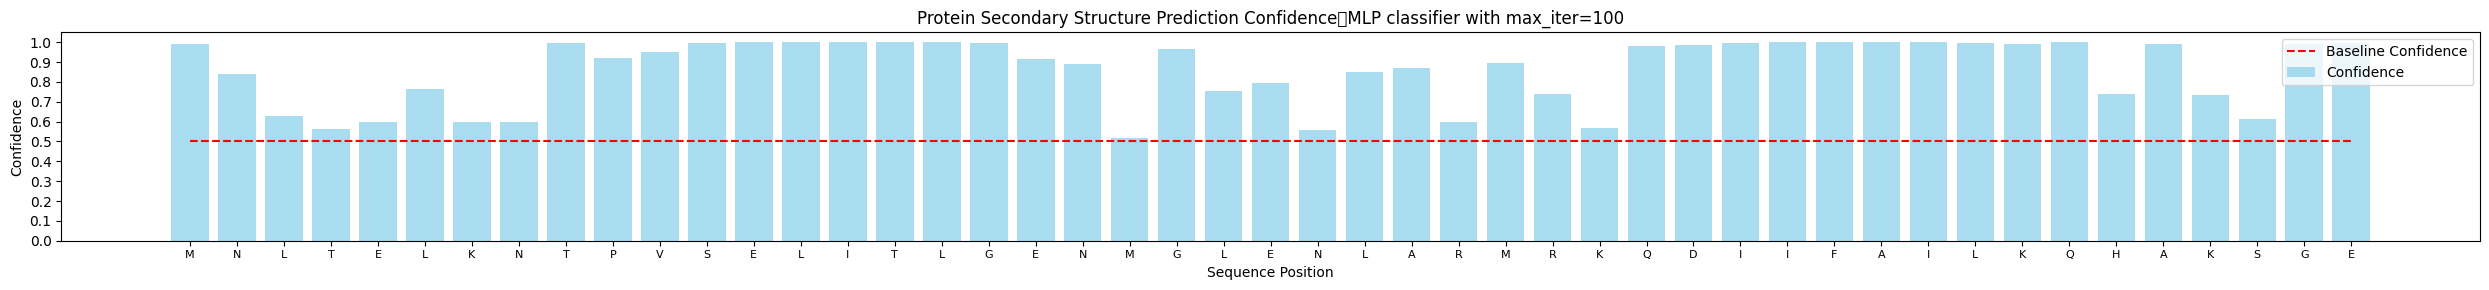


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:--H-HH----HHHHHHHHHHH------H--HHHHHHHHHHH-HH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


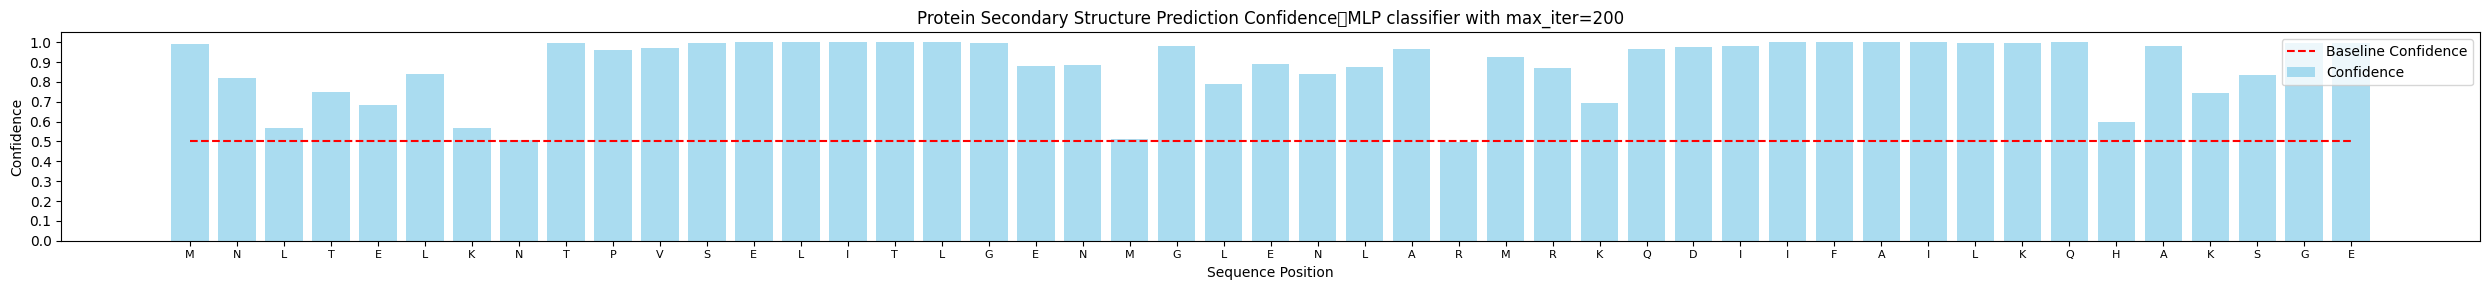


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:--H-HH----HHHHHHHHHHH---------HHHHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


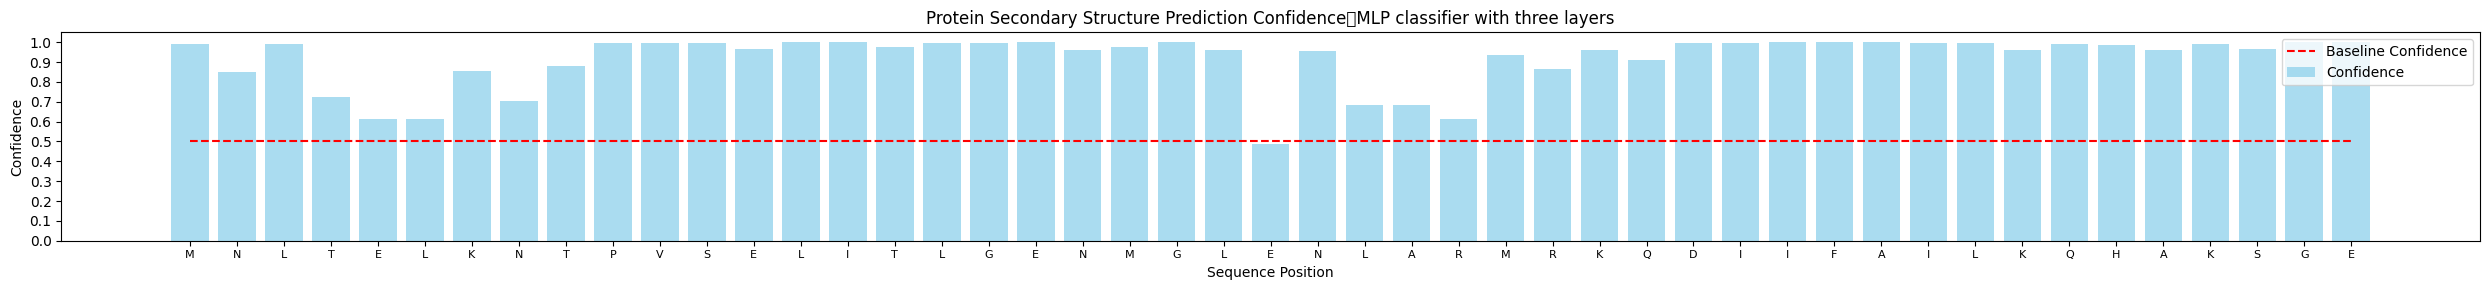


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:-EHHH-H---HHHHHHHHHH----HH----HHHHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


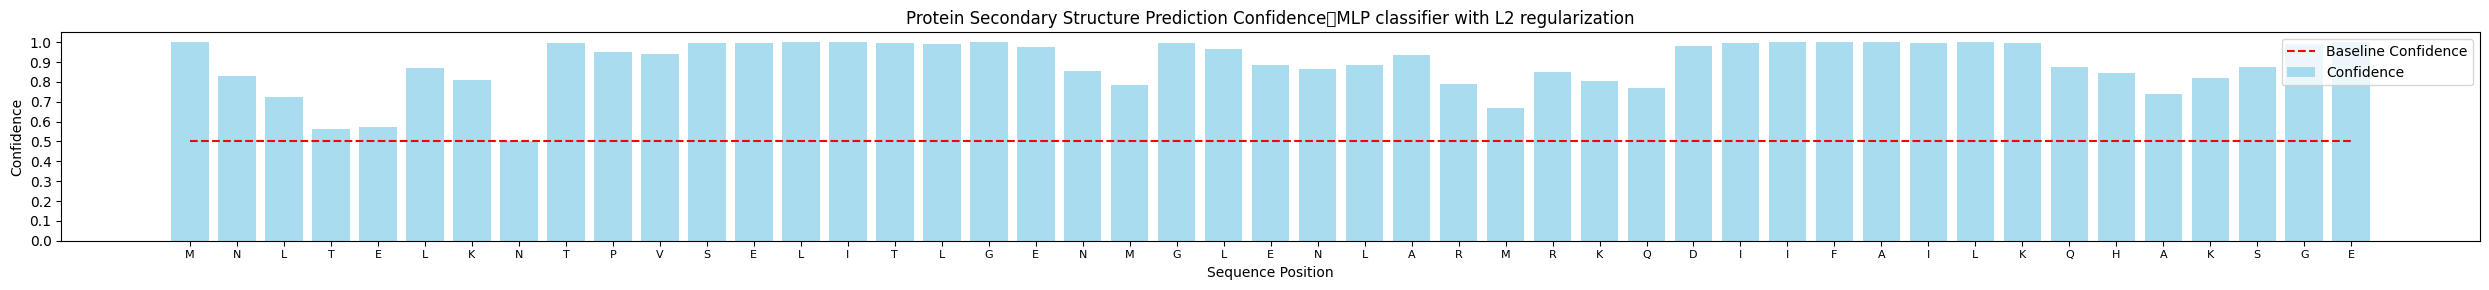


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:-EH-HH----HHHHHHHHHH-------HH-HHHHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


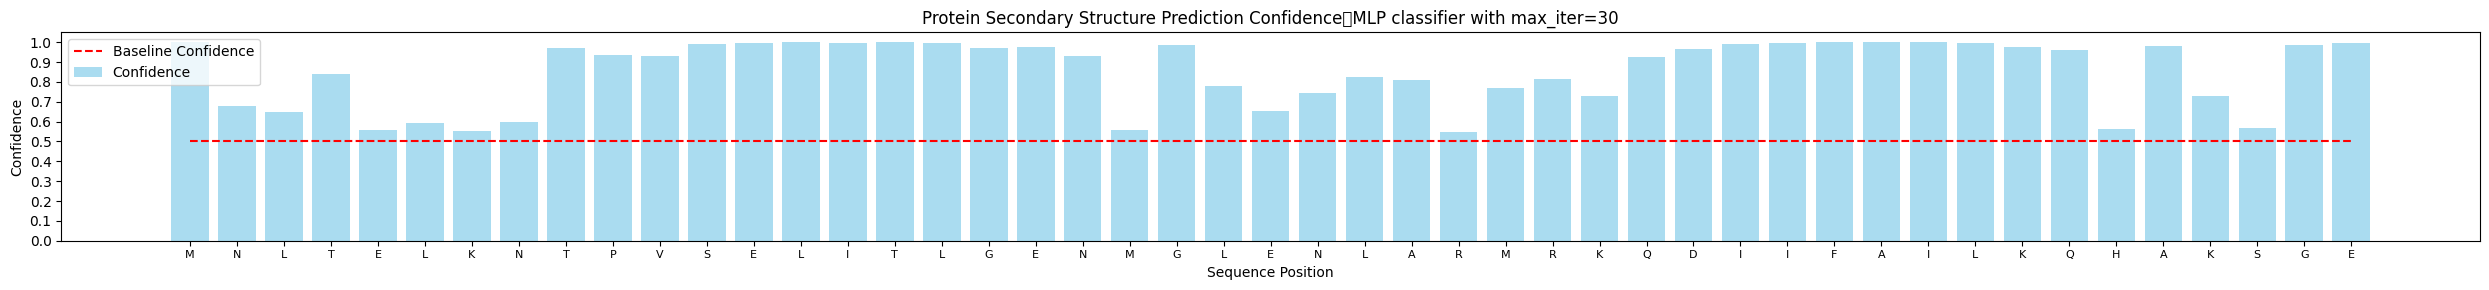


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:----HHH---HHHHHHHHHH----H--H--HHHHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


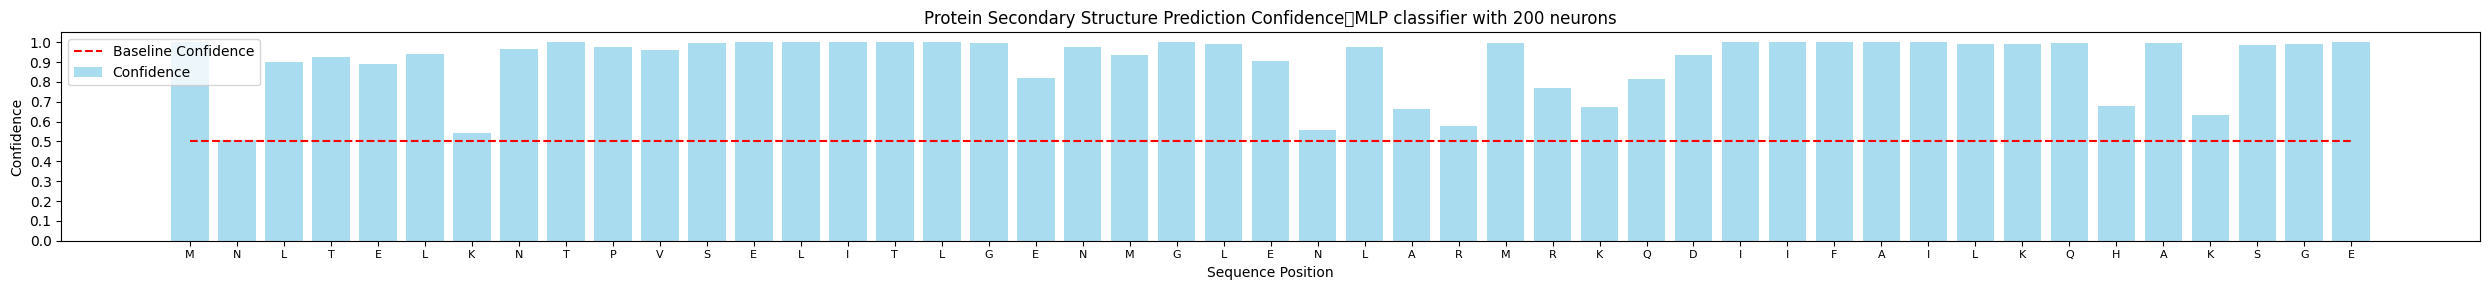


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:-EHHHH----HHHHHHHHHH----H-----HHHHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


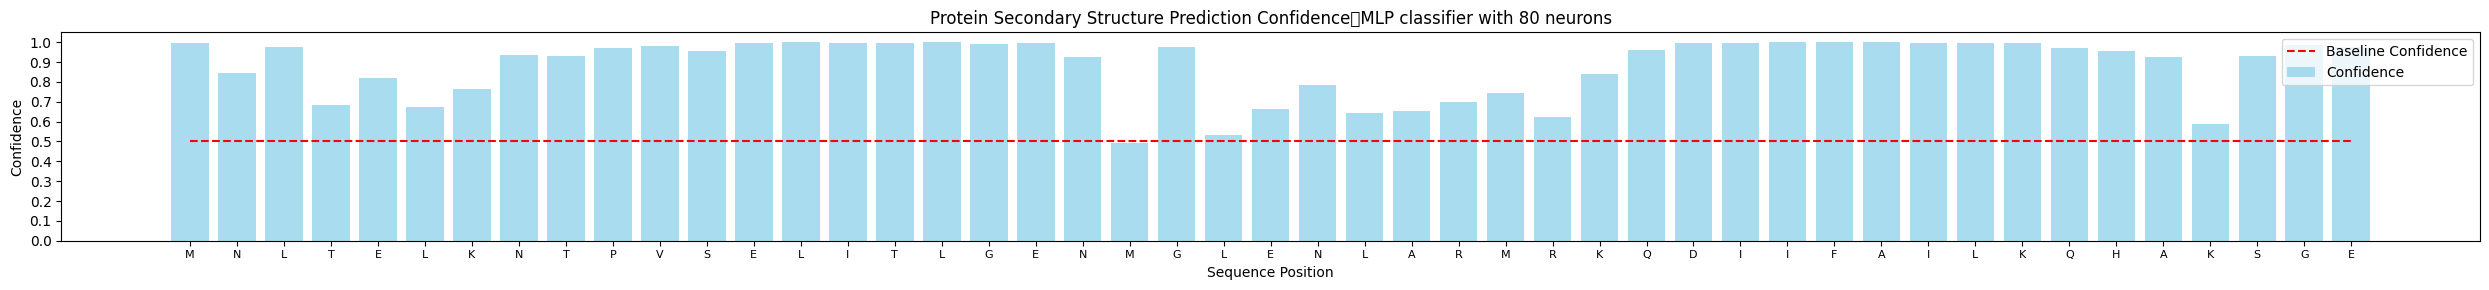


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:--HH-HH---HHHHHHHHHH----------HHHHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


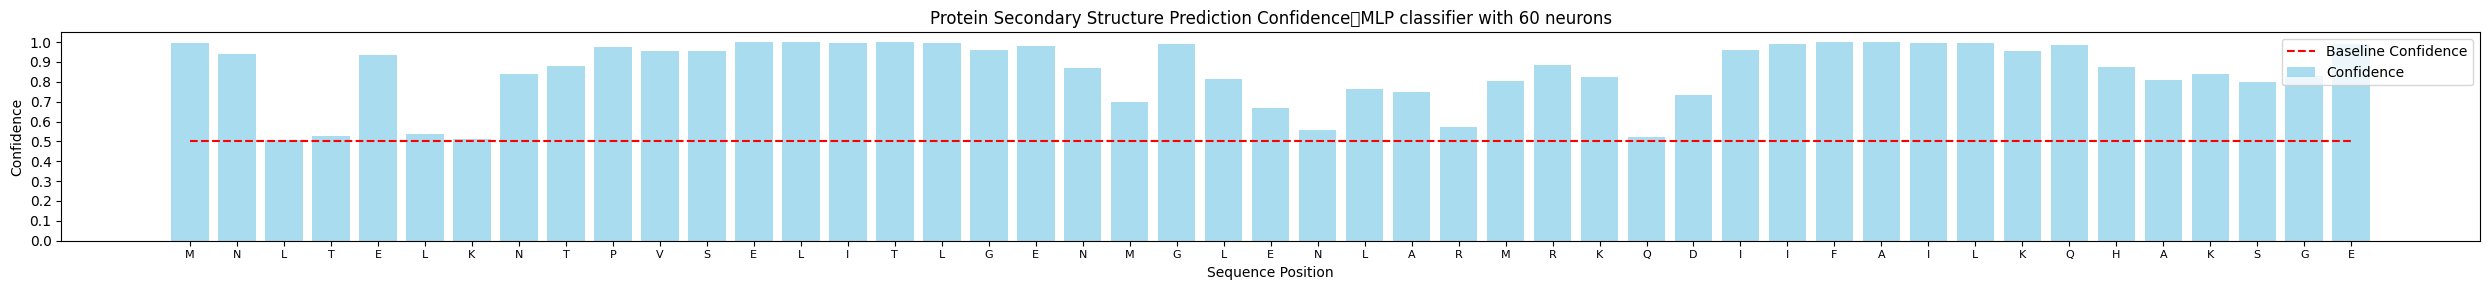


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:---HHH----HHHHHHHHHH----------H-HHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


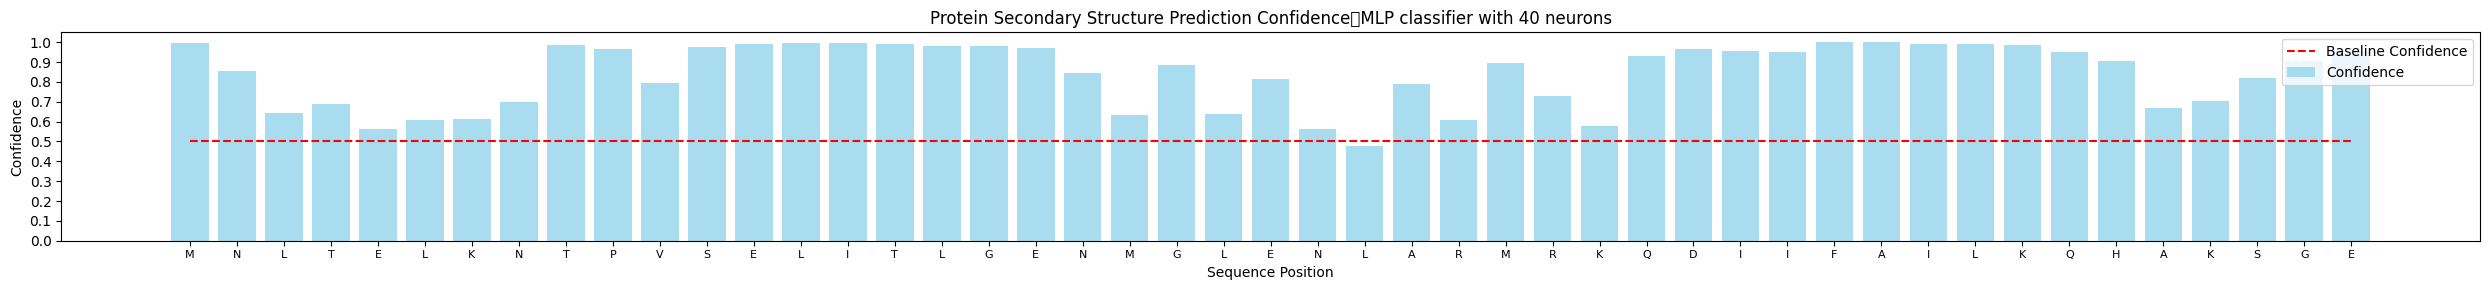


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:--H-HHH---HHHHHHHHHH-----------HHHHHHHHHHHHH---


<ipython-input-79-0856233d05c8>:87: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


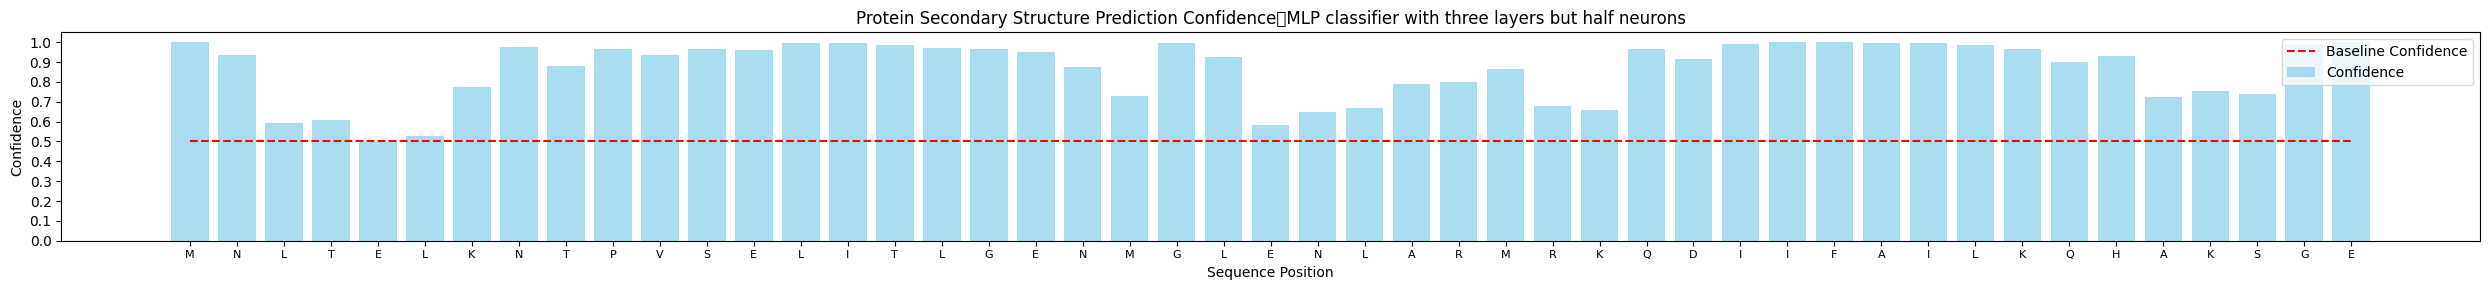


Sequence: MNLTELKNTPVSELITLGENMGLENLARMRKQDIIFAILKQHAKSGE
Structure:--HH------HHHHHHHHHH-----H-----HHHHHHHHHHHHH---

Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
q
Exiting program.


In [111]:
def secondary_structure_prediction_sequence():
  for model_name, model_path in method1_model_dict.items():
    model = joblib.load(model_path)
    predicted_dssp, predicted_confidences = predict_secondary_structure_from_sequence(sequence, model)
    visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences, model_name)
def secondary_structure_prediction_pssm():
  uploaded_files = files.upload()
  for model_name, model_path in method1_model_dict.items():
    model = joblib.load(model_path)
    upload_pssm_and_process(model_name, model, uploaded_files)


while True:
    print("\nPredict secondary structure based a primary sequence or a PSSM file."+
      "\n(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)")
    choice = input().strip().lower()
    if choice == 'q':
        print("Exiting program.")
        break
    elif choice == '1':
        print("Please enter the protein sequence:")
        sequence = input().strip().upper()
        secondary_structure_prediction_sequence()
    elif choice == '2':
        print("Please upload your PSSM file:")
        secondary_structure_prediction_pssm()
    else:
        print("Invalid choice. Please enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit")




#2. Method 1 MLP with MSA frequencies and protein sequence as input
Note: The only difference between this method and the previous one is that it uses the MSA frequencies information in the PSSM file instead of the PSSM information as one of the inputs. The purpose of this section is to explore the impact of different inputs on accuracy (Given PSSM has richer information than MSA)

## 2.1 Model Training

###2.1.1 Load packages

In [112]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import os.path
import joblib

### 2.1.2 Process data into a format consistent with neural network

In [113]:
def parse_pssm(pssm_filename):
    profile = []
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        for line in pssm_lines[3:-6]:
            profile_line = []
            # Use MSA frequencies as one of the inputs
            for n in line.rstrip().split()[22:-2]:
                profile_line.append(float(n)/100)
            profile.append(profile_line)
    return profile

def parse_dssp(dssp_filename):
    ss = ''
    with open(dssp_filename) as dssp:
        dssp.readline()
        ss = dssp.readline().rstrip()
    return ss

def seq_to_profile(seq):
    profile = []
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    for res in seq:
        profile_line = []
        for aa in aa_list:
            if res == aa:
                profile_line.append(1)
            else:
                profile_line.append(0)
        profile.append(profile_line)
    return profile

ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}



###2.1.3 Model training

In [114]:

X, y = [], []

window_size = 17

with open('/content/protein-ss-pred/data/training/list.txt') as id_list:

    for line in id_list:
        line = line.rstrip()

        profile = np.array(parse_pssm('/content/protein-ss-pred/data/training/pssm/'+line+'.pssm'))
        if np.sum(profile) != 0:
            ss = parse_dssp('/content/protein-ss-pred/data/training/dssp/'+line+'.dssp')
            ss = ss.replace('C','-')
            for i in range(0, len(profile)):
                half_window_size = int((window_size-1)/2)
                part1 = np.zeros(20*max(0, half_window_size-i))
                part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
                part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
                vec = np.concatenate((part1, part2, part3))
                X.append(vec.tolist())
                y.append(ss_map[ss[i]])

# Train a MLP classifier
model_msa_mlp = MLPClassifier(random_state=1, max_iter=30)
model_msa_mlp.fit(X, y)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=30, random_state=1)

###2.1.4 Model testing

In [115]:
# Predicting using trained MLP Method on a blind test set
dssp_true = []
dssp_pred = []
with open('/content/protein-ss-pred/data/blindTest/list.txt') as id_list:

    for line in id_list:
        line = line.rstrip()
        profile = np.array(parse_pssm('/content/protein-ss-pred/data/blindTest/pssm/'+line+'.pssm'))


        ss = parse_dssp('/content/protein-ss-pred/data/blindTest/dssp/'+line+'.dssp')
        ss = ss.replace('C','-')

        dssp = ''

        for i in range(0, len(profile)):

            half_window_size = int((window_size-1)/2)

            part1 = np.zeros(20*max(0, half_window_size-i))
            part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
            part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
            vec = np.concatenate((part1, part2, part3))

            dssp += ['H', 'E', '-'][model_msa_mlp.predict(vec.reshape(1, -1))[0]]

        for t,p in zip(ss, dssp):
            dssp_true.append(int(ss_map[t]))
            dssp_pred.append(int(ss_map[p]))

# Calculating performance metrics for MLP method on the blind test set

accuracy = accuracy_score(dssp_true, dssp_pred)
f1 = f1_score(dssp_true, dssp_pred, average='weighted')
mcc = matthews_corrcoef(dssp_true, dssp_pred)

print('Accuracy:', accuracy)
print('F1 score (weighted average):', f1)
print('MCC:', mcc)

# 保存模型
joblib.dump(model_msa_mlp, '/content/protein-ss-pred/ss_prediction_model_msa_mlp.pkl')

Accuracy: 0.7331659585425518
F1 score (weighted average): 0.7340021976651713
MCC: 0.5935120514183211


['/content/protein-ss-pred/ss_prediction_model_msa_mlp.pkl']

In [116]:
import numpy as np
import joblib
from google.colab import files

##2.2 Secondary structure predictor with MLP

### 2.2.1 Load packages

In [117]:
import numpy as np
import joblib
from google.colab import files

### 2.2.2 Data preprocessing and visualization functions

In [118]:
def predict_secondary_structure_from_sequence(sequence, model, window_size=17):
    half_window_size = int((window_size - 1) / 2)
    profile = seq_to_profile(sequence)
    profile = np.array(profile)
    dssp = ''
    confidences = []
    for i in range(len(profile)):
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        pred_probs = model.predict_proba(vec.reshape(1, -1))[0]
        pred_class = pred_probs.argmax()
        confidence = pred_probs[pred_class]
        confidences.append(confidence)
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences

def extract_sequence_from_pssm(pssm_filename):
    sequence = ''
    with open(pssm_filename) as file:
        for _ in range(3):
            next(file)
        for line in file:
            if line.strip():
                columns = line.split()
                if len(columns) > 0 and columns[0].isdigit():
                    aa = columns[1]
                    sequence += aa
                else:
                    break
    return sequence

def predict_secondary_structure_from_pssm(pssm_filename, model, window_size=17):
    profile = np.array(parse_pssm(pssm_filename))
    dssp = ''
    confidences = []
    for i in range(len(profile)):
        half_window_size = int((window_size - 1) / 2)
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        pred_probs = model.predict_proba(vec.reshape(1, -1))[0]
        pred_class = pred_probs.argmax()
        confidence = pred_probs[pred_class]
        confidences.append(confidence)
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences



def upload_pssm_and_process():
  uploaded_files = files.upload()

  if uploaded_files:
      for filename, content in uploaded_files.items():
          with open(filename, 'wb') as f:
              f.write(content)
          pssm_filename = filename

          try:
              predicted_dssp, predicted_confidences = predict_secondary_structure_from_pssm(pssm_filename, model_msa_mlp)
              sequence = extract_sequence_from_pssm(pssm_filename)
              visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences)
          except Exception as e:
              print("An error occurred while processing the PSSM file:", e
                    ,"\nPlease check your file")
  else:
      print("No file uploaded.")

def visualize_prediction_sequence(sequence, dssp, confidences):
    positions = np.arange(len(sequence))
    plt.figure(figsize=(25, 3))
    plt.bar(positions, confidences, color='skyblue', alpha=0.7, label='Confidence')
    plt.plot(positions, [0.5] * len(sequence), 'r--', label='Baseline Confidence')
    plt.xticks(positions, sequence, fontsize=8)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Sequence Position')
    plt.ylabel('Confidence')
    plt.title('Protein Secondary Structure Prediction Confidence')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\nSequence: " + sequence)
    print("Structure:" + dssp)


###2.2.3 Main function


Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
2
Please upload your PSSM file:


Saving d1acoa1.pssm to d1acoa1.pssm


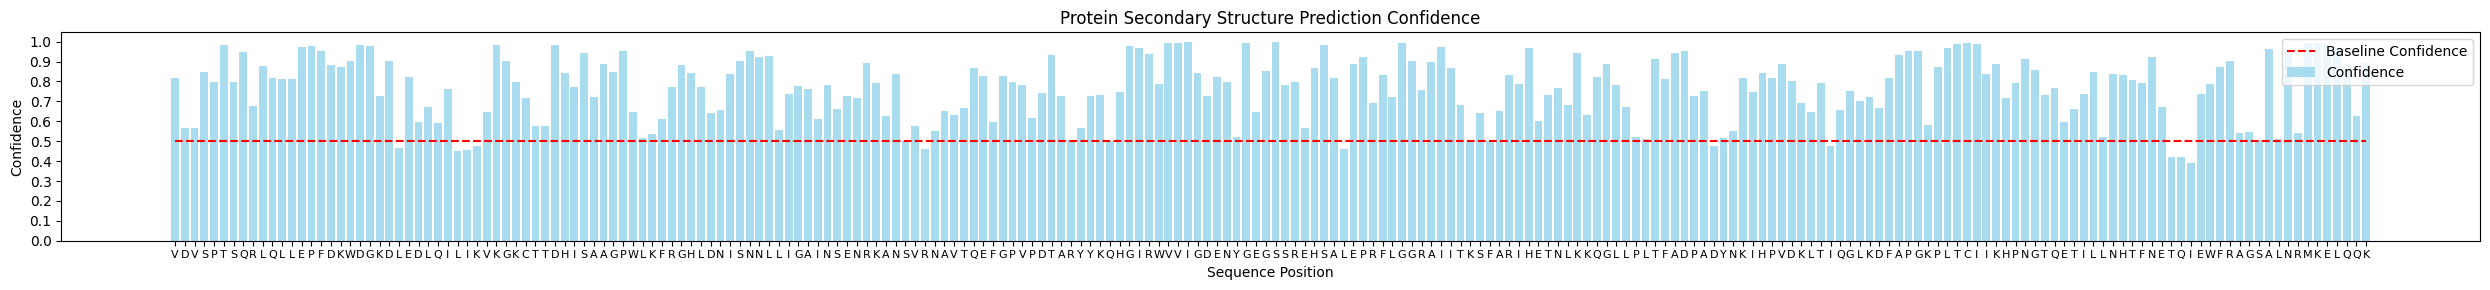


Sequence: VDVSPTSQRLQLLEPFDKWDGKDLEDLQILIKVKGKCTTDHISAAGPWLKFRGHLDNISNNLLIGAINSENRKANSVRNAVTQEFGPVPDTARYYKQHGIRWVVIGDENYGEGSSREHSALEPRFLGGRAIITKSFARIHETNLKKQGLLPLTFADPADYNKIHPVDKLTIQGLKDFAPGKPLTCIIKHPNGTQETILLNHTFNETQIEWFRAGSALNRMKELQQK
Structure:--E------EE------------H---EEEEH-----E------------H--------------H-H-------H-------------HHHH---H----EEEEE---E-------HHH-HHHH---EEEEE--H-HHHHHHHHH--EE-EEE----H--------EEEEE---------EEEEEEE-----EEEEE-------E--HHHH---HHHHHHHHHH-

Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
1
Please enter the protein sequence:
NYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYKDYKDDD


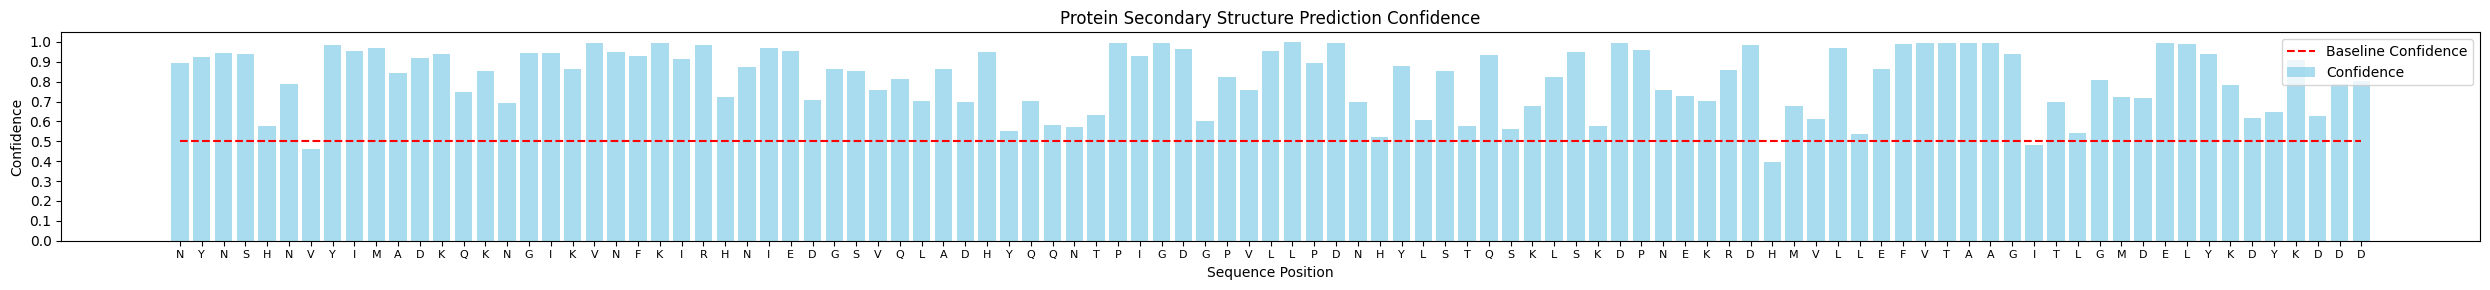


Sequence: NYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYKDYKDDD
Structure:-------EEEEE------EE-EEEEEE---H-HEEHH---H------EE-E-----E-EEH------H-HHHHEHHH-HHHHHHHHH--HHHHHHHH----

Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
q
Exiting program.


In [119]:
def interactive_secondary_structure_prediction():
    # Load the model
    model_msa_mlp = joblib.load('/content/protein-ss-pred/ss_prediction_model_msa_mlp.pkl')

    while True:
        print("\nPredict secondary structure based a primary sequence or a PSSM file."+
          "\n(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)")
        choice = input().strip().lower()

        if choice == 'q':
            print("Exiting program.")
            break
        elif choice == '1':
            print("Please enter the protein sequence:")
            sequence = input().strip().upper()
            predicted_dssp, predicted_confidences = predict_secondary_structure_from_sequence(sequence, model_msa_mlp)
            visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences)
        elif choice == '2':
            print("Please upload your PSSM file:")
            upload_pssm_and_process()
        else:
            print("Invalid choice. Please enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit")

# Run the interactive prediction program
interactive_secondary_structure_prediction()

#3. Method 2 RNN with PSSM and protein sequence as input

##3.1 Model Training

###3.1.1 Load packages

In [127]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import os


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, TimeDistributed, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

###3.1.2 Process data into a format consistent with neural network

In [128]:
def parse_pssm(pssm_filename):
    profile = []
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        for line in pssm_lines[3:-6]:
            profile_line = []
            for n in line.rstrip().split()[2:22]:
                profile_line.append(int(n))
            profile.append(profile_line)
    return profile


def parse_dssp(dssp_filename):
    ss = ''
    with open(dssp_filename) as dssp:
        dssp.readline()
        ss = dssp.readline().rstrip()
    return ss

def seq_to_profile(seq):
    profile = []
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    for res in seq:
        profile_line = []
        for aa in aa_list:
            if res == aa:
                profile_line.append(1)
            else:
                profile_line.append(0)
        profile.append(profile_line)
    return profile

ss_map = {'H': 0, 'E': 1, '-': 2, 'C':2}

def load_data(list_filename, pssm_path, dssp_path):
    X, y = [], []
    with open(list_filename) as id_list:
        for line in id_list:
            line = line.strip()

            profile = np.array(parse_pssm(os.path.join(pssm_path, line + '.pssm')))

            ss = parse_dssp(os.path.join(dssp_path, line + '.dssp'))
            ss = ss.replace('C','-')
            # Ensure that the PSSM and DSSP lengths are consistent
            if len(profile) != len(ss):
                continue

            X.append(profile)
            y.append([ss_map[s] for s in ss])

    # Fill in X and y
    X_padded = pad_sequences(X, padding='post', dtype='float32')
    y_padded = pad_sequences(y, padding='post', value=ss_map['-'])

    #Convert y to categorical format
    y_categorical = to_categorical(y_padded, num_classes=len(ss_map))

    return X_padded, y_categorical

list_filename = '/content/protein-ss-pred/data/training/list.txt'
pssm_path = '/content/protein-ss-pred/data/training/pssm'
dssp_path = '/content/protein-ss-pred/data/training/dssp'
X, y = load_data(list_filename, pssm_path, dssp_path)





###3.1.3 Model training

In [129]:
def build_rnn_model(input_shape, output_dim):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        TimeDistributed(Dense(output_dim, activation='softmax'))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_rnn_model((X.shape[1], X.shape[2]), 4)
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
15/15 [==============================] - 20s 1s/step - loss: 1.2261 - accuracy: 0.8309 - val_loss: 0.9182 - val_accuracy: 0.8893
Epoch 2/10
15/15 [==============================] - 14s 974ms/step - loss: 0.3425 - accuracy: 0.9099 - val_loss: 0.2307 - val_accuracy: 0.8948
Epoch 3/10
15/15 [==============================] - 14s 975ms/step - loss: 0.1905 - accuracy: 0.9163 - val_loss: 0.2096 - val_accuracy: 0.9086
Epoch 4/10
15/15 [==============================] - 16s 1s/step - loss: 0.1762 - accuracy: 0.9235 - val_loss: 0.1983 - val_accuracy: 0.9162
Epoch 5/10
15/15 [==============================] - 14s 957ms/step - loss: 0.1665 - accuracy: 0.9287 - val_loss: 0.1864 - val_accuracy: 0.9219
Epoch 6/10
15/15 [==============================] - 14s 979ms/step - loss: 0.1588 - accuracy: 0.9325 - val_loss: 0.1782 - val_accuracy: 0.9258
Epoch 7/10
15/15 [==============================] - 15s 995ms/step - loss: 0.1527 - accuracy: 0.9354 - val_loss: 0.1714 - val_accuracy: 0.9285
Epoch

###3.1.4 Model testing

In [130]:
# Assume that the maximum sequence length is the length used during training
max_seq_length = 759  # Or set according to the maximum length in the actual training data

dssp_true = []
dssp_pred = []

with open('/content/protein-ss-pred/data/blindTest/list.txt') as id_list:
    for line in id_list:
        line = line.rstrip()
        profile = np.array(parse_pssm('/content/protein-ss-pred/data/blindTest/pssm/'+line+'.pssm'))
        ss = parse_dssp('/content/protein-ss-pred/data/blindTest/dssp/'+line+'.dssp')
        ss = ss.replace('C','-')

        # Uniformly pad all sequences to the same maximum length
        profile_padded = pad_sequences([profile], maxlen=max_seq_length, padding='post', dtype='float32')

        # Use the model to make predictions
        predictions = model.predict(profile_padded)

        # Convert prediction results from one-hot encoding back to category labels
        predictions = np.argmax(predictions, axis=-1).flatten()

        true_labels = [ss_map[s] for s in ss]

        dssp_true.extend(true_labels)
        dssp_pred.extend(predictions[:len(true_labels)])

accuracy = accuracy_score(dssp_true, dssp_pred)
f1 = f1_score(dssp_true, dssp_pred, average='weighted')
mcc = matthews_corrcoef(dssp_true, dssp_pred)

print('RNN model Accuracy:', accuracy)
print('RNN model F1 score (weighted average):', f1)
print('RNN model MCC:', mcc)
model.save('/content/protein-ss-pred/ss_prediction_model_RNN.keras')

1/1 [==============================] - 0s 74ms/step
RNN model Accuracy: 0.6946214754731557
RNN model F1 score (weighted average): 0.6916088149951622
RNN model MCC: 0.5314450627102737


##3.2 Secondary structure predictor with RNN

###3.2.1  Load packages

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

###3.2.2 Data preprocessing and visualization functions

In [132]:
def visualize_prediction_sequence_with_confidence(sequence, dssp_predicted, confidences):
    confidences = confidences[:len(sequence)]
    positions = np.arange(len(sequence))
    plt.figure(figsize=(len(sequence) * 0.3, 4))
    bars = plt.bar(positions, confidences, color='skyblue', alpha=0.7, label='Prediction Confidence')

    for bar, confidence in zip(bars, confidences):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(confidence, 2), va='bottom')  # va: vertical alignment

    plt.xticks(positions, list(sequence), fontsize=10, rotation='vertical')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xlabel('Sequence Position')
    plt.ylabel('Confidence')
    plt.title('Protein Secondary Structure Prediction Confidence')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\nSequence:            " + sequence)
    print("Predicted Structure: " + dssp_predicted)

def predict_secondary_structure_with_confidence_from_sequence(sequence, model, max_seq_length):
    profile = seq_to_profile(sequence)
    profile_padded = pad_sequences([profile], maxlen=max_seq_length, padding='post', dtype='float32')
    predictions = model.predict(profile_padded)
    predicted_classes = np.argmax(predictions, axis=-1).flatten()
    confidences = np.max(predictions, axis=-1).flatten()
    # Convert predicted categories back to DSSP representation
    dssp_predicted = ''.join(['H', 'E', '-'][i] for i in predicted_classes[:len(sequence)])
    # Adjust the confidence array according to the original sequence length to avoid additional confidence values due to padding
    confidences_adjusted = confidences[:len(sequence)]

    return dssp_predicted, confidences_adjusted

def predict_secondary_structure_with_confidence_from_pssm(pssm_filename, model, max_seq_length):
    profile = np.array(parse_pssm(pssm_filename))
    profile_padded = pad_sequences([profile], maxlen=max_seq_length, padding='post', dtype='float32')
    predictions = model.predict(profile_padded)
    confidences = np.max(predictions, axis=-1).flatten()
    predicted_classes = np.argmax(predictions, axis=-1).flatten()
    dssp_predicted = ''.join(['H', 'E', '-'][i] for i in predicted_classes[:len(profile)])
    return dssp_predicted, confidences[:len(profile)]

def extract_sequence_from_pssm(pssm_filename):
    sequence = ''
    with open(pssm_filename) as file:
        for _ in range(3):
            next(file)
        for line in file:
            if line.strip():
                columns = line.split()
                if len(columns) > 0 and columns[0].isdigit():
                    aa = columns[1]
                    sequence += aa
                else:
                    break
    return sequence

model_path = '/content/protein-ss-pred/ss_prediction_model_RNN.keras'
model = load_model(model_path)
max_seq_length = 759




###3.2.3 Main function

Saving d1a12a_.pssm to d1a12a_ (5).pssm
1/1 [==============================] - 1s 927ms/step


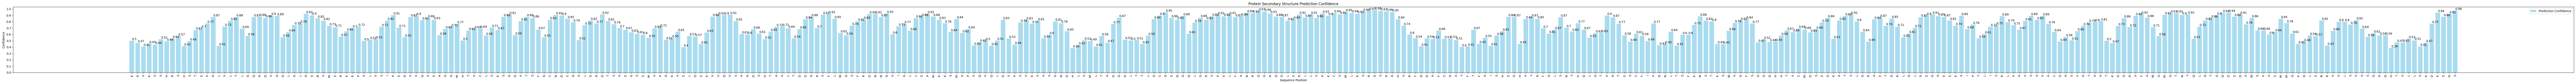


Sequence:            KKVKVSHRSHSTEPGLVLTLGQGDVGQLGLGENVMERKKPALVSIPEDVVQAEAGGMHTVCLSKSGQVYSFGCNDEGALGRDTSVEGSEMVPGKVELQEKVVQVSAGDSHTAALTDDGRVFLWGSFRDNNGVIGLLEPMKKSMVPVQVQLDVPVVKVASGNDHLVMLTADGDLYTLGCGEQGQLGRVPELFANRGGRQGLERLLVPKCVMLKSRGSRGHVRFQDAFCGAYFTFAISHEGHVYGFGLSNYHQLGTPGTESCFIPQNLTSFKNSTKSWVGFSGGQHHTVCMDSEGKAYSLGRAEYGRLGLGEGAEEKSIPTLISRLPAVSSVACGASVGYAVTKDGRVFAWGMGTNYQLGTGQDEDAWSPVEMMGKQLENRVVLSVSSGGQHTVLLVKDKEQS
Predicted Structure: --HH---HHHE----EEEEE------E--------------------EEEEEEE----EEEE-----EEEE------E----------E-E-EEEE--EEEEEEEE---EEEEE----EEEEE----------------------EHHHH---EEEEE-----EEE--H---EE-----------------------------------------------HHHHHH---EEHEE-----EEEEE-----EE-------E-E--EEE-------EEEEEEE--EEEEEE-----EEEEEE----EE------------EEE-----EEEEEE--EEEEEEE---EEEEE-------------------EEEEEE-----EEEEEEEE--HHEEEEH-----


In [133]:
from google.colab import files

uploaded_files = files.upload()

if uploaded_files:
    for filename, content in uploaded_files.items():
        with open(filename, 'wb') as f:
            f.write(content)
        pssm_filename = filename

        try:
            predicted_dssp, confidences = predict_secondary_structure_with_confidence_from_pssm(pssm_filename, model, max_seq_length)
            sequence = extract_sequence_from_pssm(pssm_filename)
            visualize_prediction_sequence_with_confidence(sequence, predicted_dssp, confidences)
        except Exception as e:
            print("An error occurred while processing the PSSM file:", e
                  ,"\nPlease check your file")
else:
    print("No file uploaded.")


#4.Method 3 CNN with PSSM and protein sequence as input

##4.1 Model Training

###4.1.1 Load packages

In [134]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os.path

# Importing necessary libraries for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

###4.1.2 Process data into a format consistent with neural network

In [135]:

# Utility functions to parse data fasta, dssp and pssm features

def parse_pssm(pssm_filename):
    profile = []
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        for line in pssm_lines[3:-6]:  # Skip non-data lines at the beginning and end
            profile_line = []
            # PSSM scores typically located from columns 2-21 on each line
            # following position number and amino acid identifier
            for n in line.rstrip().split()[2:22]:
                profile_line.append(int(n))  # PSSM scores are integers
            profile.append(profile_line)
    return profile

def parse_dssp(dssp_filename):
    ss = ''
    with open(dssp_filename) as dssp:
        dssp.readline()  # Skip first line
        ss = dssp.readline().rstrip()
    return ss

def seq_to_profile(seq):
    profile = []
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    for res in seq:
        profile_line = []
        for aa in aa_list:
            if res == aa:
                profile_line.append(1)
            else:
                profile_line.append(0)
        profile.append(profile_line)
    return profile

ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}

X, y = [], []

window_size = 17

with open('/content/protein-ss-pred/data/training/list.txt') as id_list:
    for line in id_list:
        line = line.rstrip()
        profile = np.array(parse_pssm('/content/protein-ss-pred/data/training/pssm/'+line+'.pssm'))
        if np.sum(profile) != 0:
            ss = parse_dssp('/content/protein-ss-pred/data/training/dssp/'+line+'.dssp')
            ss = ss.replace('C','-')
            for i in range(0, len(profile)):
                half_window_size = int((window_size-1)/2)
                part1 = np.zeros(20*max(0, half_window_size-i))
                part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
                part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
                vec = np.concatenate((part1, part2, part3))
                X.append(vec.tolist())
                y.append(ss_map[ss[i]])

# Convert to numpy arrays for compatibility with CNN
X = np.array(X)
y = np.array(y)

# Reshape X for CNN input
X = X.reshape(-1, 17, 20)

###4.1.3 Model training

In [136]:

# Define the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(17, 20)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Assuming 3 output classes (H, E, -)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model.save('/content/protein-ss-pred/ss_prediction_cnn_model.keras')


Epoch 1/10
4954/4954 [==============================] - 35s 7ms/step - loss: 0.6131 - accuracy: 0.7425 - val_loss: 0.5898 - val_accuracy: 0.7585
Epoch 2/10
4954/4954 [==============================] - 31s 6ms/step - loss: 0.5486 - accuracy: 0.7728 - val_loss: 0.5509 - val_accuracy: 0.7726
Epoch 3/10
4954/4954 [==============================] - 33s 7ms/step - loss: 0.5299 - accuracy: 0.7805 - val_loss: 0.5546 - val_accuracy: 0.7729
Epoch 4/10
4954/4954 [==============================] - 35s 7ms/step - loss: 0.5169 - accuracy: 0.7860 - val_loss: 0.5518 - val_accuracy: 0.7757
Epoch 5/10
4954/4954 [==============================] - 35s 7ms/step - loss: 0.5062 - accuracy: 0.7899 - val_loss: 0.5606 - val_accuracy: 0.7690
Epoch 6/10
4954/4954 [==============================] - 35s 7ms/step - loss: 0.4977 - accuracy: 0.7937 - val_loss: 0.5554 - val_accuracy: 0.7724
Epoch 7/10
4954/4954 [==============================] - 34s 7ms/step - loss: 0.4896 - accuracy: 0.7959 - val_loss: 0.5780 - val_ac

###4.1.4 Model testing

In [137]:
model = load_model('/content/protein-ss-pred/ss_prediction_cnn_model.keras')

X_test, y_test = [], []
with open('/content/protein-ss-pred/data/blindTest/list.txt') as id_list:
    for line in id_list:
        line = line.rstrip()
        profile = np.array(parse_pssm('/content/protein-ss-pred/data/blindTest/pssm/'+line+'.pssm'))
        ss = parse_dssp('/content/protein-ss-pred/data/blindTest/dssp/'+line+'.dssp')
        ss = ss.replace('C','-')
        for i in range(0, len(profile)):
            half_window_size = int((window_size-1)/2)
            part1 = np.zeros(20*max(0, half_window_size-i))
            part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
            part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
            vec = np.concatenate((part1, part2, part3))
            X_test.append(vec.tolist())
            y_test.append(ss_map[ss[i]])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(-1, 17, 20)

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

print("CNN Model Accuracy: ", accuracy)
print("CNN Model F1 Score: ", f1)
print("CNN Model MCC: ", mcc)


1942/1942 [==============================] - 7s 3ms/step
CNN Model Accuracy:  0.737511265610918
CNN Model F1 Score:  0.7393780205726401
CNN Model MCC:  0.6035403552768114


##4.2 Secondary structure predictor with CNN

###4.2.1  Load packages

In [138]:
import numpy as np
import joblib
from google.colab import files

###4.2.2 Data preprocessing and visualization functions

In [139]:
# Define utility functions for parsing and prediction
def predict_secondary_structure_from_sequence(sequence, model, window_size=17):
    profile = seq_to_profile(sequence)
    profile = np.array(profile)
    dssp = ''
    confidences = []
    for i in range(len(profile)):
        half_window_size = int((window_size - 1) / 2)
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        vec = vec.reshape(1, window_size, 20)
        pred_probs = model.predict(vec)[0]
        pred_class = np.argmax(pred_probs)
        confidence = pred_probs[pred_class]
        confidences.append(confidence)
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences



def extract_sequence_from_pssm(pssm_filename):
    sequence = ''
    with open(pssm_filename) as file:
        for _ in range(3):
            next(file)
        for line in file:
            if line.strip():
                columns = line.split()
                if len(columns) > 0 and columns[0].isdigit():
                    aa = columns[1]
                    sequence += aa
                else:
                    break
    return sequence

def predict_secondary_structure_from_pssm(pssm_filename, model, window_size=17):
    profile = np.array(parse_pssm(pssm_filename))
    dssp = ''
    confidences = []
    for i in range(len(profile)):
        half_window_size = int((window_size - 1) / 2)
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        vec = vec.reshape(1, window_size, 20)
        pred_probs = model.predict(vec)[0]
        pred_class = np.argmax(pred_probs)
        confidence = pred_probs[pred_class]
        confidences.append(confidence)
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences




def upload_pssm_and_process():
  uploaded_files = files.upload()

  if uploaded_files:
      for filename, content in uploaded_files.items():
          with open(filename, 'wb') as f:
              f.write(content)
          pssm_filename = filename

          try:
              predicted_dssp, predicted_confidences = predict_secondary_structure_from_pssm(pssm_filename, model)
              sequence = extract_sequence_from_pssm(pssm_filename)
              visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences)
          except Exception as e:
              print("An error occurred while processing the PSSM file:", e
                    ,"\nPlease check your file")
  else:
      print("No file uploaded.")

def visualize_prediction_sequence(sequence, dssp, confidences):
    positions = np.arange(len(sequence))
    plt.figure(figsize=(25, 3))
    plt.bar(positions, confidences, color='skyblue', alpha=0.7, label='Confidence')
    plt.plot(positions, [0.5] * len(sequence), 'r--', label='Baseline Confidence')
    plt.xticks(positions, sequence, fontsize=8)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Sequence Position')
    plt.ylabel('Confidence')
    plt.title('Protein Secondary Structure Prediction Confidence')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\nSequence: " + sequence)
    print("Structure:" + dssp)




###4.2.3 Main function

Saving d1a1xa_.pssm to d1a1xa_.pssm
1/1 [==============================] - 0s 22ms/step


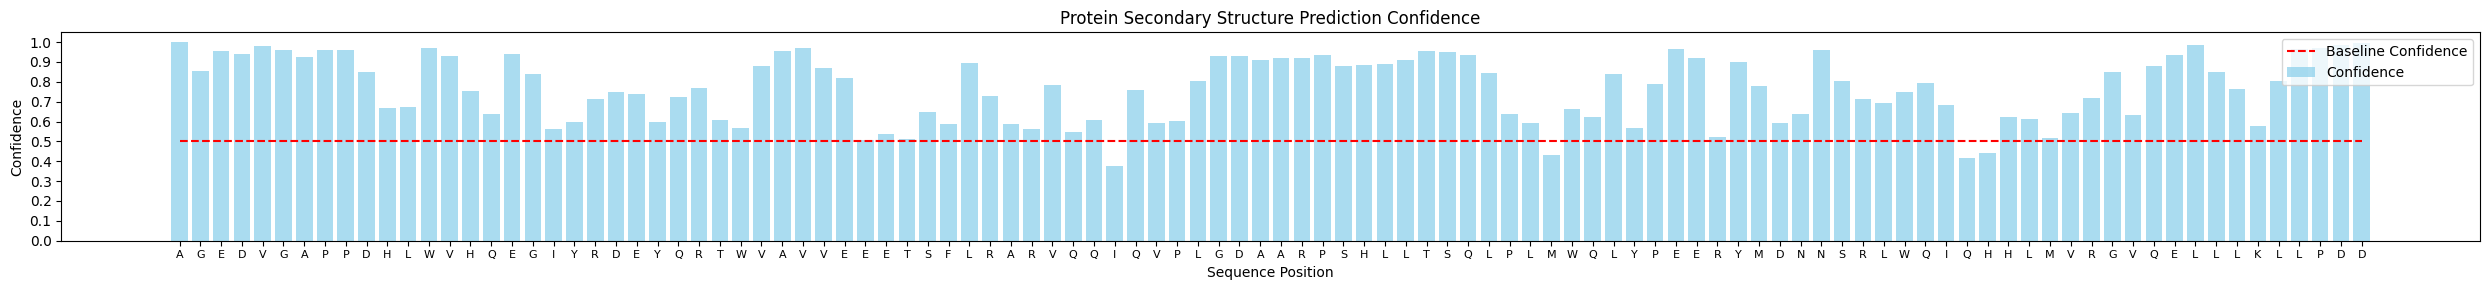


Sequence: AGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQQIQVPLGDAARPSHLLTSQLPLMWQLYPEERYMDNNSRLWQIQHHLMVRGVQELLLKLLPDD
Structure:----------EEEEE----E------EEEEEEEE-E-----HEEEEE--------------------EEE-----EE-----EEEE--------HHHHHHEH----

Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
q
Exiting program.


In [141]:
model = tf.keras.models.load_model('/content/protein-ss-pred/ss_prediction_cnn_model.keras')
upload_pssm_and_process()
import tensorflow as tf

def interactive_secondary_structure_prediction():
    # Load the model
    model = tf.keras.models.load_model('/content/protein-ss-pred/ss_prediction_cnn_model.keras')

    while True:
        print("\nPredict secondary structure based a primary sequence or a PSSM file."+
          "\n(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)")
        choice = input().strip().lower()

        if choice == 'q':
            print("Exiting program.")
            break
        elif choice == '1':
            print("Please enter the protein sequence:")
            sequence = input().strip().upper()
            predicted_dssp, predicted_confidences = predict_secondary_structure_from_sequence(sequence, model)
            visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences)
        elif choice == '2':
            print("Please upload your PSSM file:")
            upload_pssm_and_process()
        else:
            print("Invalid choice. Please enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit")

# Run the interactive prediction program
interactive_secondary_structure_prediction()


#5.Method 4 Transformer with PSSM and protein sequence as input

##5.1 Model Training

In [122]:
import numpy as np
import scipy.stats as stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

def parse_pssm(pssm_filename):
    profile = []
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        for line in pssm_lines[3:-6]:
            profile_line = []
            # PSSM scores typically located from columns 2-21 on each line, following position number and amino acid identifier
            for n in line.rstrip().split()[2:22]:
                profile_line.append(int(n))
            profile.append(profile_line)
    return profile

def parse_dssp(dssp_filename):
    ss = ''
    with open(dssp_filename) as dssp:
        dssp.readline()
        ss = dssp.readline().rstrip()
    return ss

def seq_to_profile(seq):
    profile = []
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    for res in seq:
        profile_line = []
        for aa in aa_list:
            if res == aa:
                profile_line.append(1)
            else:
                profile_line.append(0)
        profile.append(profile_line)
    return profile

ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}

X, y = [], []

window_size = 17

with open('/content/protein-ss-pred/data/training/list.txt') as id_list:
    for line in id_list:
        line = line.rstrip()
        profile = np.array(parse_pssm('/content/protein-ss-pred/data/training/pssm/'+line+'.pssm'))
        if np.sum(profile) != 0:
            ss = parse_dssp('/content/protein-ss-pred/data/training/dssp/'+line+'.dssp')
            ss = ss.replace('C','-')
            for i in range(0, len(profile)):
                half_window_size = int((window_size-1)/2)
                part1 = np.zeros(20*max(0, half_window_size-i))
                part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
                part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
                vec = np.concatenate((part1, part2, part3))
                X.append(vec.tolist())
                y.append(ss_map[ss[i]])

# Convert to numpy arrays for compatibility with Transformer
X = np.array(X)
y = np.array(y)

# Reshape X for Transformer input
X = X.reshape(-1, 17, 20)

# Define Transformer model
def transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    # Transformer Encoder layers
    x = Conv1D(64, 3, activation='relu')(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.1)(x)
    x = Conv1D(32, 3, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Define Transformer parameters
input_shape = (17, 20)
num_classes = 3  # Assuming 3 output classes (H, E, -)

# Create Transformer model
model_transformer = transformer_model(input_shape, num_classes)

# Compile the model
optimizer = Adam(lr=1e-4)
model_transformer.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_transformer.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
4954/4954 [==============================] - 136s 27ms/step - loss: 0.7189 - accuracy: 0.6627 - val_loss: 0.6893 - val_accuracy: 0.6763
Epoch 2/10
4954/4954 [==============================] - 135s 27ms/step - loss: 0.6604 - accuracy: 0.6950 - val_loss: 0.6966 - val_accuracy: 0.6760
Epoch 3/10
4954/4954 [==============================] - 110s 22ms/step - loss: 0.6304 - accuracy: 0.7100 - val_loss: 0.6957 - val_accuracy: 0.6796
Epoch 4/10
4954/4954 [==============================] - 124s 25ms/step - loss: 0.6058 - accuracy: 0.7216 - val_loss: 0.6917 - val_accuracy: 0.6922
Epoch 5/10
4954/4954 [==============================] - 119s 24ms/step - loss: 0.5865 - accuracy: 0.7326 - val_loss: 0.6951 - val_accuracy: 0.6899
Epoch 6/10
4954/4954 [==============================] - 141s 29ms/step - loss: 0.5684 - accuracy: 0.7417 - val_loss: 0.7154 - val_accuracy: 0.6863
Epoch 7/10
4954/4954 [==============================] - 139s 28ms/step - loss: 0.5523 - accuracy: 0.7485 - val_loss: 0

##5.2 Model Testing

In [123]:
import numpy as np
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

X_test, y_test = [], []
with open('/content/protein-ss-pred/data/blindTest/list.txt') as id_list:
    for line in id_list:
        line = line.rstrip()
        profile = np.array(parse_pssm('/content/protein-ss-pred/data/blindTest/pssm/'+line+'.pssm'))
        ss = parse_dssp('/content/protein-ss-pred/data/blindTest/dssp/'+line+'.dssp')
        ss = ss.replace('C','-')
        for i in range(0, len(profile)):
            half_window_size = int((window_size-1)/2)
            part1 = np.zeros(20*max(0, half_window_size-i))
            part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
            part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
            vec = np.concatenate((part1, part2, part3))
            X_test.append(vec.tolist())
            y_test.append(ss_map[ss[i]])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(-1, 17, 20)

predictions = model_transformer.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

print("Model Transformer Accuracy: ", accuracy)
print("Model Transformer F1 Score: ", f1)
print("Model Transformer MCC: ", mcc)
# Save the model
model_transformer.save('/content/protein-ss-pred/ss_prediction_transformer_model.keras')

1942/1942 [==============================] - 12s 6ms/step
Model Transformer Accuracy:  0.6453746620316725
Model Transformer F1 Score:  0.6458766460304742
Model Transformer MCC:  0.46352891134503066


##5.3 Secondary structure predictor with transformer


Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
2
Please upload your PSSM file:


Saving d1a1xa_.pssm to d1a1xa_ (1).pssm
1/1 [==============================] - 0s 46ms/step


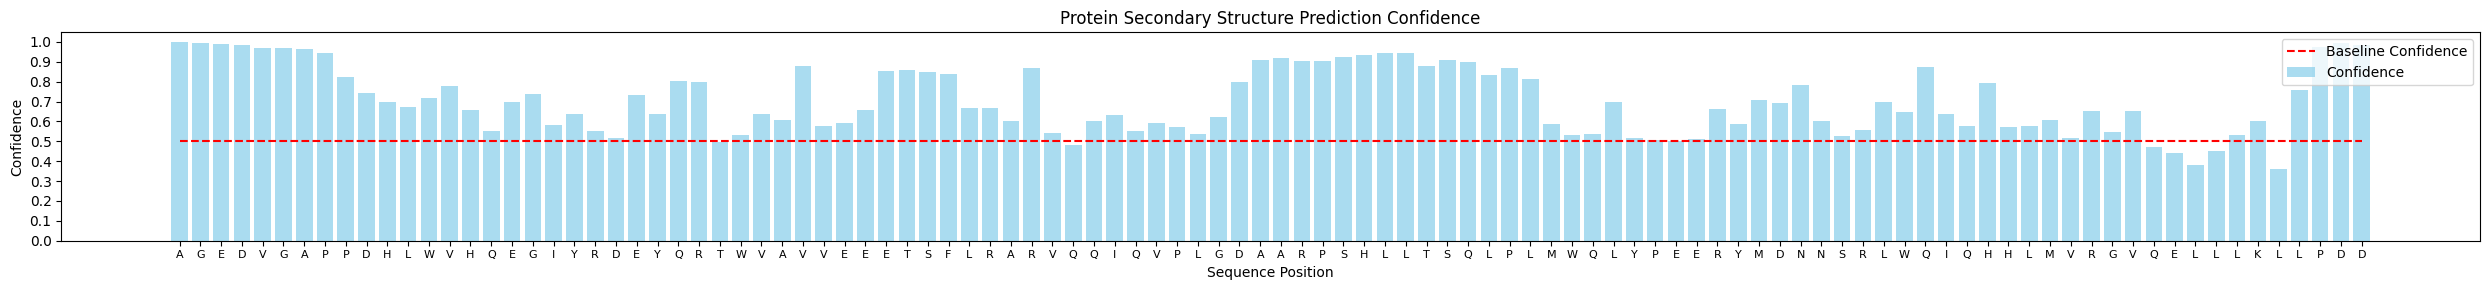


Sequence: AGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQQIQVPLGDAARPSHLLTSQLPLMWQLYPEERYMDNNSRLWQIQHHLMVRGVQELLLKLLPDD
Structure:----------EEE-----------HH-EEEEE-------EEE--EE-EEE-----------------E---E-EEEEEEEE-EEEEEEEE----H---EHH-----

Predict secondary structure based a primary sequence or a PSSM file.
(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)
q
Exiting program.


In [142]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
from google.colab import files

def predict_secondary_structure_from_sequence(sequence, model, window_size=17):
    profile = seq_to_profile(sequence)
    profile = np.array(profile)
    dssp = ''
    confidences = []
    for i in range(len(profile)):
        half_window_size = int((window_size - 1) / 2)
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        vec = vec.reshape(1, window_size, 20)
        pred_probs = model.predict(vec)[0]
        pred_class = np.argmax(pred_probs)
        confidence = pred_probs[pred_class]
        confidences.append(confidence)
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences


def extract_sequence_from_pssm(pssm_filename):
    sequence = ''
    with open(pssm_filename) as file:
        for _ in range(3):
            next(file)
        for line in file:
            if line.strip():
                columns = line.split()
                if len(columns) > 0 and columns[0].isdigit():
                    aa = columns[1]
                    sequence += aa
                else:
                    break
    return sequence


def predict_secondary_structure_from_pssm(pssm_filename, model, window_size=17):
    profile = np.array(parse_pssm(pssm_filename))
    dssp = ''
    confidences = []
    for i in range(len(profile)):
        half_window_size = int((window_size - 1) / 2)
        part1 = np.zeros(20 * max(0, half_window_size - i))
        part2 = np.ndarray.flatten(profile[max(0, i - half_window_size):min(i + half_window_size + 1, len(profile))])
        part3 = np.zeros(20 * max(0, half_window_size - (len(profile) - i - 1)))
        vec = np.concatenate((part1, part2, part3))
        vec = vec.reshape(1, window_size, 20)
        pred_probs = model.predict(vec)[0]
        pred_class = np.argmax(pred_probs)
        confidence = pred_probs[pred_class]
        confidences.append(confidence)
        dssp += ['H', 'E', '-'][pred_class]
    return dssp, confidences


def upload_pssm_and_process():
    uploaded_files = files.upload()

    if uploaded_files:
        for filename, content in uploaded_files.items():
            with open(filename, 'wb') as f:
                f.write(content)
            pssm_filename = filename

            try:
                predicted_dssp, predicted_confidences = predict_secondary_structure_from_pssm(pssm_filename, model_transformer)
                sequence = extract_sequence_from_pssm(pssm_filename)
                visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences)
            except Exception as e:
                print("An error occurred while processing the PSSM file:", e
                      , "\nPlease check your file")
    else:
        print("No file uploaded.")


def visualize_prediction_sequence(sequence, dssp, confidences):
    positions = np.arange(len(sequence))
    plt.figure(figsize=(25, 3))
    plt.bar(positions, confidences, color='skyblue', alpha=0.7, label='Confidence')
    plt.plot(positions, [0.5] * len(sequence), 'r--', label='Baseline Confidence')
    plt.xticks(positions, sequence, fontsize=8)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Sequence Position')
    plt.ylabel('Confidence')
    plt.title('Protein Secondary Structure Prediction Confidence')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\nSequence: " + sequence)
    print("Structure:" + dssp)


def interactive_secondary_structure_prediction():
    # Load the model
    model_transformer = tf.keras.models.load_model('/content/protein-ss-pred/ss_prediction_transformer_model.keras')

    while True:
        print("\nPredict secondary structure based a primary sequence or a PSSM file." +
              "\n(Enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit)")
        choice = input().strip().lower()

        if choice == 'q':
            print("Exiting program.")
            break
        elif choice == '1':
            print("Please enter the protein sequence:")
            sequence = input().strip().upper()
            predicted_dssp, predicted_confidences = predict_secondary_structure_from_sequence(sequence, model_transformer)
            visualize_prediction_sequence(sequence, predicted_dssp, predicted_confidences)
        elif choice == '2':
            print("Please upload your PSSM file:")
            upload_pssm_and_process()
        else:
            print("Invalid choice. Please enter '1' for primary sequence or '2' for PSSM file, or 'q' to exit")


# Run the interactive prediction program
interactive_secondary_structure_prediction()
